In [22]:
#Install AIF360
!pip install 'aif360[all]'

random_state = 42

In [23]:
%matplotlib inline
from matplotlib import pyplot as plt
from os import getenv
import os.path as path
import numpy as np
import pandas as pd

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder

from aif360.sklearn.preprocessing import Reweighing, ReweighingMeta
from aif360.sklearn.inprocessing import AdversarialDebiasing
from aif360.sklearn.postprocessing import CalibratedEqualizedOdds, PostProcessingMeta
from aif360.sklearn.datasets import fetch_adult
from aif360.sklearn.metrics import disparate_impact_ratio, average_odds_error, generalized_fpr
from aif360.sklearn.metrics import generalized_fnr, difference

## Loading data

### Adult dataset

Datasets are formatted as separate `X` (# samples x # features) and `y` (# samples x # labels) DataFrames. The index of each DataFrame contains protected attribute values per sample. Datasets may also load a `sample_weight` object to be used with certain algorithms/metrics. All of this makes it so that aif360 is compatible with scikit-learn objects.

For example, we can easily load the Adult dataset from UCI with the following line:

In [24]:
adult_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
               'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                'hours-per-week', 'native-country', 'income']

adult_dtypes = {
    'age': 'int64',
    'workclass': 'category',
    'fnlwgt': 'int64',
    'education': 'category',
    'education-num': 'int64',
    'marital-status': 'category',
    'occupation': 'category',
    'relationship': 'category',
    'race': 'category',
    'sex': 'category',
    'capital-gain': 'int64',
    'capital-loss': 'int64',
    'hours-per-week': 'int64',
    'native-country': 'category',
    'income': 'category'
}

adult_data = pd.read_csv(path.join(path.pardir, 'data', 'adult', 'adult.data'), index_col=None, header=None, dtype=adult_dtypes, na_values=' ?', names=adult_names, skipinitialspace=True)

adult_data.set_index(['race', 'sex'], inplace=True)
adult_data.head(10)

age         workclass  fnlwgt  education  education-num  \
race  sex                                                               
White Male     39         State-gov   77516  Bachelors             13   
      Male     50  Self-emp-not-inc   83311  Bachelors             13   
      Male     38           Private  215646    HS-grad              9   
Black Male     53           Private  234721       11th              7   
      Female   28           Private  338409  Bachelors             13   
White Female   37           Private  284582    Masters             14   
Black Female   49           Private  160187        9th              5   
White Male     52  Self-emp-not-inc  209642    HS-grad              9   
      Female   31           Private   45781    Masters             14   
      Male     42           Private  159449  Bachelors             13   

                     marital-status         occupation   relationship  \
race  sex                                                               
White Male            Never-married       Adm-clerical  Not-in-family   
      Male       Married-civ-spouse    Exec-managerial        Husband   
      Male                 Divorced  Handlers-cleaners  Not-in-family   
Black Male       Married-civ-spouse  Handlers-cleaners        Husband   
      Female     Married-civ-spouse     Prof-specialty           Wife   
White Female     Married-civ-spouse    Exec-managerial           Wife   
Black Female  Married-spouse-absent      Other-service  Not-in-family   
White Male       Married-civ-spouse    Exec-managerial        Husband   
      Female          Never-married     Prof-specialty  Not-in-family   
      Male       Married-civ-spouse    Exec-managerial        Husband   

              capital-gain  capital-loss  hours-per-week native-country income  
race  sex                                                                       
White Male            2174             0              40  United-States  <=50K  
      Male               0             0              13  United-States  <=50K  
      Male               0             0              40  United-States  <=50K  
Black Male               0             0              40  United-States  <=50K  
      Female             0             0              40           Cuba  <=50K  
White Female             0             0              40  United-States  <=50K  
Black Female             0             0              16        Jamaica  <=50K  
White Male               0             0              45  United-States   >50K  
      Female         14084             0              50  United-States   >50K  
      Male            5178             0              40  United-States   >50K

We can then map the protected attributes to integers,

In [25]:
y = adult_data['income']
X = adult_data.drop(columns='income')

X.index = pd.MultiIndex.from_arrays(X.index.codes, names=X.index.names)
y.index = pd.MultiIndex.from_arrays(y.index.codes, names=y.index.names)

and the target classes to 0/1,

In [26]:
y = pd.Series(y.factorize(sort=True)[0], index=y.index, name=y.name)

split the dataset,

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=random_state)

and finally, one-hot encode the categorical features:

In [28]:
ohe = make_column_transformer(
        (OneHotEncoder(sparse_output=False), X_train.dtypes == 'category'),
        remainder='passthrough', verbose_feature_names_out=False)
X_train  = pd.DataFrame(ohe.fit_transform(X_train), columns=ohe.get_feature_names_out(), index=X_train.index)
X_test = pd.DataFrame(ohe.transform(X_test), columns=ohe.get_feature_names_out(), index=X_test.index)

X_train.head(10)

workclass_?  workclass_Federal-gov  workclass_Local-gov  \
race sex                                                            
4    0            0.0                    0.0                  0.0   
0    1            0.0                    0.0                  0.0   
4    1            0.0                    0.0                  0.0   
     0            0.0                    0.0                  1.0   
     0            0.0                    0.0                  0.0   
     1            0.0                    0.0                  0.0   
     0            0.0                    0.0                  0.0   
0    0            0.0                    0.0                  0.0   
2    1            0.0                    0.0                  0.0   
4    1            0.0                    0.0                  0.0   

          workclass_Never-worked  workclass_Private  workclass_Self-emp-inc  \
race sex                                                                      
4    0                       0.0                0.0                     0.0   
0    1                       0.0                0.0                     0.0   
4    1                       0.0                0.0                     0.0   
     0                       0.0                0.0                     0.0   
     0                       0.0                1.0                     0.0   
     1                       0.0                1.0                     0.0   
     0                       0.0                1.0                     0.0   
0    0                       0.0                0.0                     0.0   
2    1                       0.0                1.0                     0.0   
4    1                       0.0                1.0                     0.0   

          workclass_Self-emp-not-inc  workclass_State-gov  \
race sex                                                    
4    0                           1.0                  0.0   
0    1                           1.0                  0.0   
4    1                           0.0                  1.0   
     0                           0.0                  0.0   
     0                           0.0                  0.0   
     1                           0.0                  0.0   
     0                           0.0                  0.0   
0    0                           1.0                  0.0   
2    1                           0.0                  0.0   
4    1                           0.0                  0.0   

          workclass_Without-pay  education_10th  ...  \
race sex                                         ...   
4    0                      0.0             0.0  ...   
0    1                      0.0             0.0  ...   
4    1                      0.0             0.0  ...   
     0                      0.0             0.0  ...   
     0                      0.0             0.0  ...   
     1                      0.0             0.0  ...   
     0                      0.0             0.0  ...   
0    0                      0.0             0.0  ...   
2    1                      0.0             0.0  ...   
4    1                      0.0             0.0  ...   

          native-country_Trinadad&Tobago  native-country_United-States  \
race sex                                                                 
4    0                               0.0                           1.0   
0    1                               0.0                           1.0   
4    1                               0.0                           1.0   
     0                               0.0                           1.0   
     0                               0.0                           1.0   
     1                               0.0                           0.0   
     0                               0.0                           1.0   
0    0                               0.0                           1.0   
2    1                               0.0                           0.0   
4    1      

Note: the column names are lost in this transformation. The same encoding can be done with Pandas, but this cannot be combined with other preprocessing in a Pipeline.

In [29]:
pd.get_dummies(X).head(10)

age  fnlwgt  education-num  capital-gain  capital-loss  \
race sex                                                           
4    1     39   77516             13          2174             0   
     1     50   83311             13             0             0   
     1     38  215646              9             0             0   
2    1     53  234721              7             0             0   
     0     28  338409             13             0             0   
4    0     37  284582             14             0             0   
2    0     49  160187              5             0             0   
4    1     52  209642              9             0             0   
     0     31   45781             14         14084             0   
     1     42  159449             13          5178             0   

          hours-per-week  workclass_?  workclass_Federal-gov  \
race sex                                                       
4    1                40        False                  False   
     1                13        False                  False   
     1                40        False                  False   
2    1                40        False                  False   
     0                40        False                  False   
4    0                40        False                  False   
2    0                16        False                  False   
4    1                45        False                  False   
     0                50        False                  False   
     1                40        False                  False   

          workclass_Local-gov  workclass_Never-worked  ...  \
race sex                                               ...   
4    1                  False                   False  ...   
     1                  False                   False  ...   
     1                  False                   False  ...   
2    1                  False                   False  ...   
     0                  False                   False  ...   
4    0                  False                   False  ...   
2    0                  False                   False  ...   
4    1                  False                   False  ...   
     0                  False                   False  ...   
     1                  False                   False  ...   

          native-country_Portugal  native-country_Puerto-Rico  \
race sex                                                        
4    1                      False                       False   
     1                      False                       False   
     1                      False                       False   
2    1                      False                       False   
     0                      False                       False   
4    0                      False                       False   
2    0                      False                       False   
4    1                      False                       False   
     0                      False                       False   
     1                      False                       False   

          native-country_Scotland  native-country_South  \
race sex                                                  
4    1                      False                 False   
     1                      False                 False   
     1                      False                 False   
2    1                      False                 False   
     0                      False                 False   
4    0                      False                 False   
2    0                      False                 False   
4    1                      False                 False   
     0                      False                 False   
     1                      False                 False   

          native-country_Taiwan  native-country_Thailand  \
race sex                                                   
4    1                    False                    False   
     1   

The protected attribute information is also replicated in the labels:

In [30]:
y_train.head(10)

race  sex
4     0      0
0     1      1
4     1      0
      0      0
      0      0
      1      0
      0      1
0     0      0
2     1      0
4     1      0
Name: income, dtype: int64

## Running metrics

With the data in this format, we can easily train a scikit-learn model and get predictions for the test data:

In [31]:
y_pred = LogisticRegression(solver='liblinear').fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_pred)

0.8021291841539564

Now, we can analyze our predictions and quickly calculate the disparate impact for females vs. males:

In [32]:
disparate_impact_ratio(y_test, y_pred, prot_attr='sex')

0.4937724865882336

And similarly, we can assess how close the predictions are to equality of odds.

`average_odds_error()` computes the (unweighted) average of the absolute values of the true positive rate (TPR) difference and false positive rate (FPR) difference, i.e.:

$$ \tfrac{1}{2}\left(|FPR_{D = \text{unprivileged}} - FPR_{D = \text{privileged}}| + |TPR_{D = \text{unprivileged}} - TPR_{D = \text{privileged}}|\right) $$

In [33]:
average_odds_error(y_test, y_pred, priv_group=(1, 1))

0.04298455872306367

In that case, we chose to look at the intersection of all protected attributes (race and sex) and designate a single combination (white males) as privileged.

If we wish to do something more complex, we can pass a custom array of protected attributes, like so (note: this choice of protected groups is just for demonstration):

In [34]:
race = y_test.index.get_level_values('race').to_numpy()
sex = y_test.index.get_level_values('sex').to_numpy()
prot_attr = np.where(race ^ sex, 0, 1)
disparate_impact_ratio(y_test, y_pred, prot_attr=prot_attr)

0.6026490933864375

## Debiasing algorithms

`ReweighingMeta` is a workaround until changing sample weights can be handled properly in `Pipeline`/`GridSearchCV`

In [35]:
rew = ReweighingMeta(estimator=LogisticRegression(solver='liblinear'),
                     reweigher=Reweighing('sex'))

params = {'estimator__C': [1, 10]}

clf = GridSearchCV(rew, params, scoring='accuracy', cv=5)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print(clf.best_params_)

0.8015149964172382
{'estimator__C': 1}


In [36]:
disparate_impact_ratio(y_test, clf.predict(X_test), prot_attr='sex')

0.4867537360361544

Rather than trying to weight accuracy and fairness, we can try a fair in-processing algorithm:

In [37]:
adv_deb = AdversarialDebiasing(prot_attr='sex', random_state=random_state)
adv_deb.fit(X_train, y_train)
adv_deb.score(X_test, y_test)

0.7631282628723514

In [38]:
average_odds_error(y_test, adv_deb.predict(X_test), prot_attr='sex')

0.0

Note that `AdversarialDebiasing` creates a TensorFlow session which we should close when we're finished to free up resources:

In [39]:
adv_deb.sess_.close()

Finally, let's try a post-processor, `CalibratedEqualizedOdds`.

Since the post-processor needs to be trained on data unseen by the original estimator, we will use the `PostProcessingMeta` class which splits the data and trains the estimator and post-processor with their own split.

In [40]:
cal_eq_odds = CalibratedEqualizedOdds('sex', cost_constraint='fnr', random_state=random_state)
log_reg = LogisticRegression(solver='liblinear')
postproc = PostProcessingMeta(estimator=log_reg, postprocessor=cal_eq_odds, random_state=random_state)

postproc.fit(X_train, y_train)
accuracy_score(y_test, postproc.predict(X_test))

0.7967038591462791

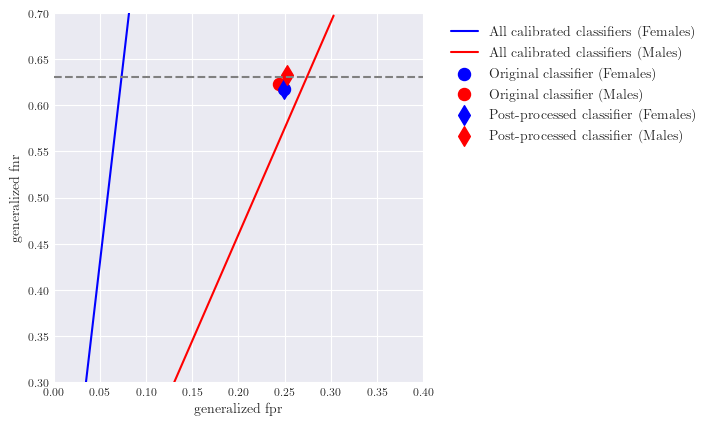

In [41]:
y_pred = postproc.predict_proba(X_test)[:, 1]
y_lr = postproc.estimator_.predict_proba(X_test)[:, 1]
br = postproc.postprocessor_.base_rates_
i = X_test.index.get_level_values('sex') == 1

plt.style.use('seaborn-v0_8-darkgrid')
if getenv('TEXLIVE_HOME') is not None:
    plt.style.use('tex')
    plt.rcParams['legend.fontsize'] = 10

plt.plot([0, br[0]], [0, 1-br[0]], '-b', label='All calibrated classifiers (Females)')
plt.plot([0, br[1]], [0, 1-br[1]], '-r', label='All calibrated classifiers (Males)')

plt.scatter(generalized_fpr(y_test[~i], y_lr[~i]),
            generalized_fnr(y_test[~i], y_lr[~i]),
            300, c='blue', marker='.', label='Original classifier (Females)')
plt.scatter(generalized_fpr(y_test[i], y_lr[i]),
            generalized_fnr(y_test[i], y_lr[i]),
            300, c='red', marker='.', label='Original classifier (Males)')

plt.scatter(generalized_fpr(y_test[~i], y_pred[~i]),
            generalized_fnr(y_test[~i], y_pred[~i]),
            100, c='blue', marker='d', label='Post-processed classifier (Females)')
plt.scatter(generalized_fpr(y_test[i], y_pred[i]),
            generalized_fnr(y_test[i], y_pred[i]),
            100, c='red', marker='d', label='Post-processed classifier (Males)')

plt.plot([0, 1], [generalized_fnr(y_test, y_pred)]*2, '--', c='0.5')

plt.axis('square')
plt.xlim([0.0, 0.4])
plt.ylim([0.3, 0.7])
plt.xlabel('generalized fpr')
plt.ylabel('generalized fnr')
plt.legend(bbox_to_anchor=(1.04,1), loc='upper left');

We can see the generalized false negative rate is approximately equalized and the classifiers remain close to the calibration lines.

We can quanitify the discrepancy between protected groups using the `difference` operator:

In [42]:
difference(generalized_fnr, y_test, y_pred, prot_attr='sex')

-0.014760297113748155